In [1]:
import numpy as np
import pandas as pd
import warnings
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from IPython.core.display import HTML
from rdkit.Chem.QED import qed
from rdkit.Chem import PandasTools
def show(df):
    return HTML(df.to_html(notebook=True))
PandasTools.RenderImagesInAllDataFrames(images=True)
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
 
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
results=pd.read_pickle('new_generated_suzuki_with_maccs_sim_true_structure.pkl')

In [5]:
#results.to_csv('new_generated_suzuki_with_maccs_sim_true_structure.csv')

In [6]:
#results=pd.read_pickle('generated_suzuki_with_maccs_sim.pkl')
# X = torch.tensor(results['maccs'].tolist(), dtype=torch.float32)
# y = torch.tensor(results['max_maccs_sim'].tolist(), dtype=torch.float32)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=99)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# X_train = X_train.to(device)
# X_test = X_test.to(device)
# y_train = y_train.to(device)
# y_test = y_test.to(device)

results['maccs_1d'] = results['maccs'].apply(lambda x: [item for sublist in x for item in sublist])

# X = results['maccs'].tolist()

# y = results['max_maccs_sim'].tolist()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=99)

In [7]:
results.index = range(0, 90048)
results= results.set_index(results.index)
#results

In [8]:
X = results['maccs_1d'].to_list()

In [9]:
X=pd.DataFrame(X)

In [10]:
X.head(1)

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0


In [11]:
new_columns = {}
for i in range(len(X.columns)):
    new_columns[i] = 'Feature {}'.format(i)

X.rename(columns=new_columns, inplace=True)

In [12]:
X.head(1)

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 324,Feature 325,Feature 326,Feature 327,Feature 328,Feature 329,Feature 330,Feature 331,Feature 332,Feature 333
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0


In [13]:
#X = results['maccs_1d']

y = results['max_maccs_sim']
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2,random_state=99)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5,random_state=99)
# X_train=np.array(X_train)
# X_test=np.array(X_test)
# y_train=np.array(y_train)
# y_test=np.array(y_test)


In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 存储每个模型最好的参数和验证误差
best_models = {}

# ------------------------
# 1. XGBoost Regressor
# ------------------------
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=1)
xgb_params = {
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0]
}
xgb_grid = GridSearchCV(xgb_model, xgb_params, scoring='neg_mean_squared_error', cv=cv, n_jobs=8)  # 限制外部并行核数
xgb_grid.fit(X_train, y_train)
xgb_val_pred = xgb_grid.predict(X_val)
xgb_val_mse = mean_squared_error(y_val, xgb_val_pred)
best_models['XGBoost'] = {
    'best_params': xgb_grid.best_params_,
    'val_mse': xgb_val_mse,
    'model': xgb_grid.best_estimator_
}

In [27]:
# ------------------------
# 2. Random Forest Regressor
# ------------------------
rf_model = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5],
}
rf_grid = GridSearchCV(rf_model, rf_params, scoring='neg_mean_squared_error', cv=cv, n_jobs=8)
rf_grid.fit(X_train, y_train)
rf_val_pred = rf_grid.predict(X_val)
rf_val_mse = mean_squared_error(y_val, rf_val_pred)
best_models['RandomForest'] = {
    'best_params': rf_grid.best_params_,
    'val_mse': rf_val_mse,
    'model': rf_grid.best_estimator_
}


In [29]:
# ------------------------
# 3. Lasso Regression
# ------------------------
lasso_model = Lasso(max_iter=10000, random_state=42)
lasso_params = {
    'alpha': [0.01, 0.1, 1, 10]
}
lasso_grid = GridSearchCV(lasso_model, lasso_params, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
lasso_grid.fit(X_train, y_train)
lasso_val_pred = lasso_grid.predict(X_val)
lasso_val_mse = mean_squared_error(y_val, lasso_val_pred)
best_models['Lasso'] = {
    'best_params': lasso_grid.best_params_,
    'val_mse': lasso_val_mse,
    'model': lasso_grid.best_estimator_
}

# ------------------------
# 4. Ridge Regression
# ------------------------
ridge_model = Ridge(max_iter=10000, random_state=42)
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10]
}
ridge_grid = GridSearchCV(ridge_model, ridge_params, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
ridge_grid.fit(X_train, y_train)
ridge_val_pred = ridge_grid.predict(X_val)
ridge_val_mse = mean_squared_error(y_val, ridge_val_pred)
best_models['Ridge'] = {
    'best_params': ridge_grid.best_params_,
    'val_mse': ridge_val_mse,
    'model': ridge_grid.best_estimator_
}

In [30]:
for name, info in best_models.items():
    print(f"\n{name}:")
    print(f"  Best Params: {info['best_params']}")
    print(f"  Validation MSE: {info['val_mse']:.6f}")

# 可选：找出最好的模型
best_model_name = min(best_models, key=lambda k: best_models[k]['val_mse'])
print(f"\n✅ Best model on validation set: {best_model_name} with MSE = {best_models[best_model_name]['val_mse']:.6f}")


XGBoost:
  Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 200, 'subsample': 0.8}
  Validation MSE: 0.000045

RandomForest:
  Best Params: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
  Validation MSE: 0.000159

Lasso:
  Best Params: {'alpha': 0.01}
  Validation MSE: 0.001860

Ridge:
  Best Params: {'alpha': 1}
  Validation MSE: 0.000437

✅ Best model on validation set: XGBoost with MSE = 0.000045


In [31]:
print("\n📊 Test MSE for each best model:")
for name, info in best_models.items():
    test_pred = info['model'].predict(X_test)
    test_mse = mean_squared_error(y_test, test_pred)
    print(f"{name}: Test MSE = {test_mse:.6f}")


📊 Test MSE for each best model:
XGBoost: Test MSE = 0.000045
RandomForest: Test MSE = 0.000164
Lasso: Test MSE = 0.001831
Ridge: Test MSE = 0.000433


In [34]:
best_models['XGBoost']['model']

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=1,
             num_parallel_tree=None, random_state=42, ...)

In [14]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(colsample_bytree=0.8, learning_rate=0.1, max_depth=15, n_estimators=200, subsample=0.8,random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [36]:
from sklearn import metrics
xgb_model = best_models['XGBoost']['model']
y_valid_predict=xgb_model.predict(X_val)
xgb_valid=metrics.mean_squared_error(y_val,y_valid_predict)
print('xgb_valid:',xgb_valid)
y_predict=xgb_model.predict(X_test)
xgb_test=metrics.mean_squared_error(y_test,y_predict)
print('xgb_test:',xgb_test)


xgb_valid: 4.4906295011678206e-05
xgb_test: 4.542314810816942e-05


In [37]:
4.542314810816942e-05/0.87

5.2210515066861405e-05

In [38]:
best_models

{'XGBoost': {'best_params': {'colsample_bytree': 0.8,
   'learning_rate': 0.1,
   'max_depth': 15,
   'n_estimators': 200,
   'subsample': 0.8},
  'val_mse': 4.4906295011678206e-05,
  'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=15, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=1,
               num_parallel_tree=None, random_state=42, ...)},
 'RandomForest': {'best_params': {'max_depth': 1

In [39]:
y_valid_predict_rf=best_models['RandomForest']['model'].predict(X_val)
rf_valid=metrics.mean_squared_error(y_val,y_valid_predict_rf)
y_predict_rf=best_models['RandomForest']['model'].predict(X_test)
rf_test=metrics.mean_squared_error(y_test,y_predict_rf)

y_valid_predict_ridge=best_models['Ridge']['model'].predict(X_val)
ridge_valid=metrics.mean_squared_error(y_val,y_valid_predict_ridge)
y_predict_ridge=best_models['Ridge']['model'].predict(X_test)
ridge_test=metrics.mean_squared_error(y_test,y_predict_ridge)

y_valid_predict_lasso=best_models['Lasso']['model'].predict(X_val)
lasso_valid=metrics.mean_squared_error(y_val,y_valid_predict_lasso)
y_predict_lasso=best_models['Lasso']['model'].predict(X_test)
lasso_test=metrics.mean_squared_error(y_test,y_predict_lasso)

In [40]:
print('rf_valid:',rf_valid)
print('rf_test',rf_test)

rf_valid: 0.00015896552217551545
rf_test 0.0001641952764775551


In [41]:
ridge_test

0.0004331792844001327

In [42]:
lasso_test

0.0018312505853437537

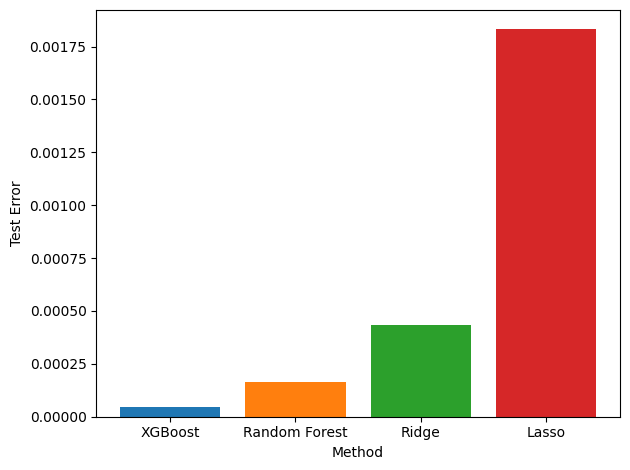

In [43]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
loss=[xgb_test,rf_test,ridge_test,lasso_test]
method=['XGBoost','Random Forest','Ridge','Lasso']
plt.bar(method, loss,color=colors)
plt.xlabel('Method')
plt.ylabel('Test Error')
#plt.show()
#plt.savefig('Figure 7 mse.png',dpi=300)
plt.tight_layout()
plt.savefig('Figure 7 mse.tiff',dpi=600)

In [ ]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

[09:45:18] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:45:25] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


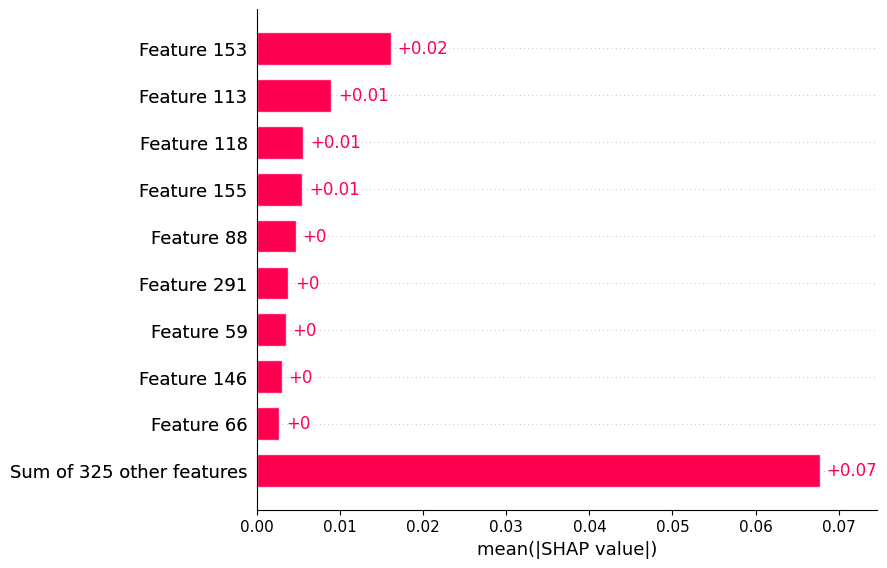

In [24]:
shap.plots.bar(shap_values, max_display=10)

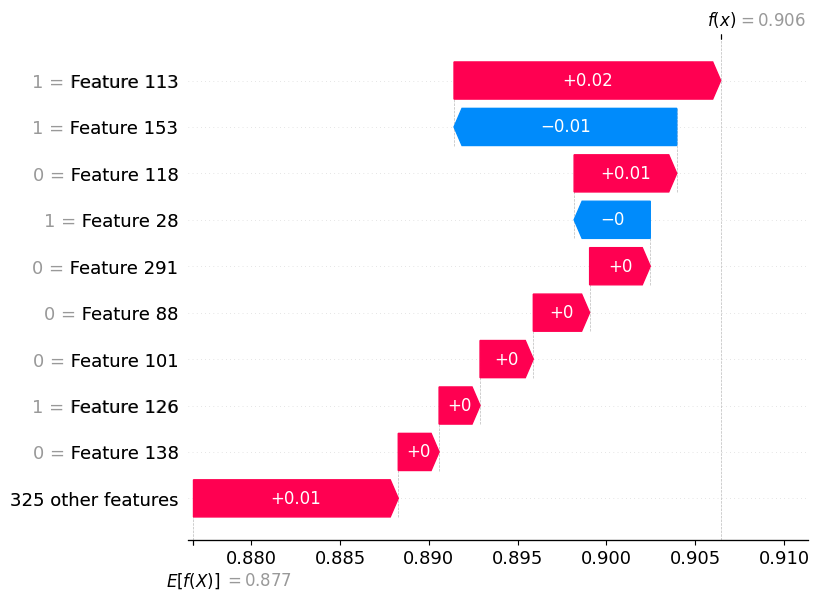

In [25]:
shap.plots.waterfall(shap_values[0]) # For the first observation

In [15]:
shap.initjs()

In [16]:

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)


[09:47:33] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


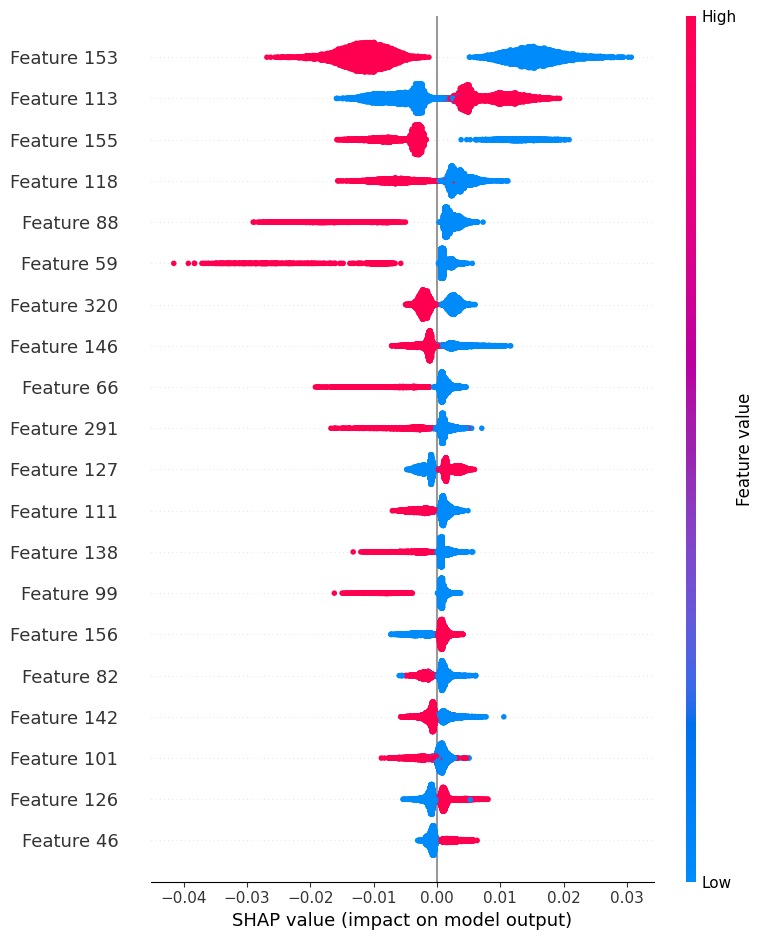

In [17]:
shap.summary_plot(shap_values, X_test)

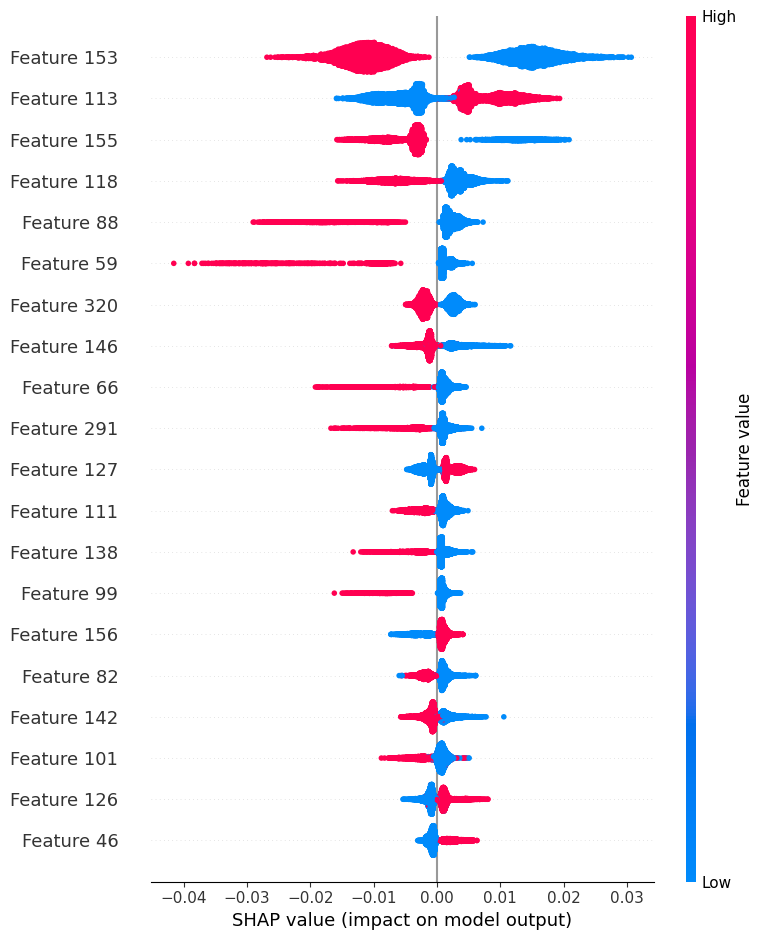

In [18]:
import matplotlib.pyplot as plt

shap.summary_plot(shap_values, X_test, show=False)
plt.savefig('Figure 8 shap_summary_plot_dpi300.jpg', dpi=300)

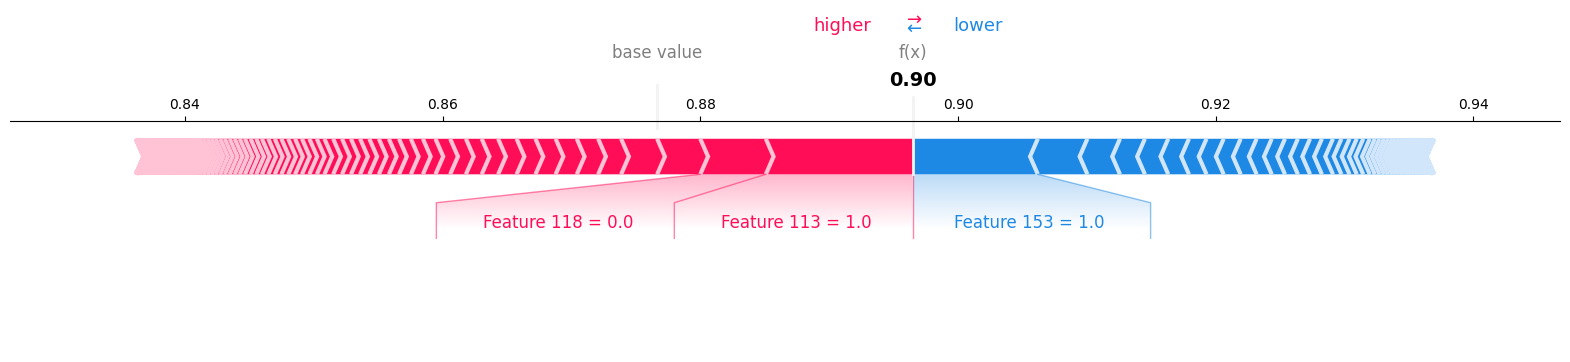

In [19]:
def p(j):
    return(shap.force_plot(explainer.expected_value, shap_values[j,:], X_test.iloc[j,:], matplotlib=True))
p(0)

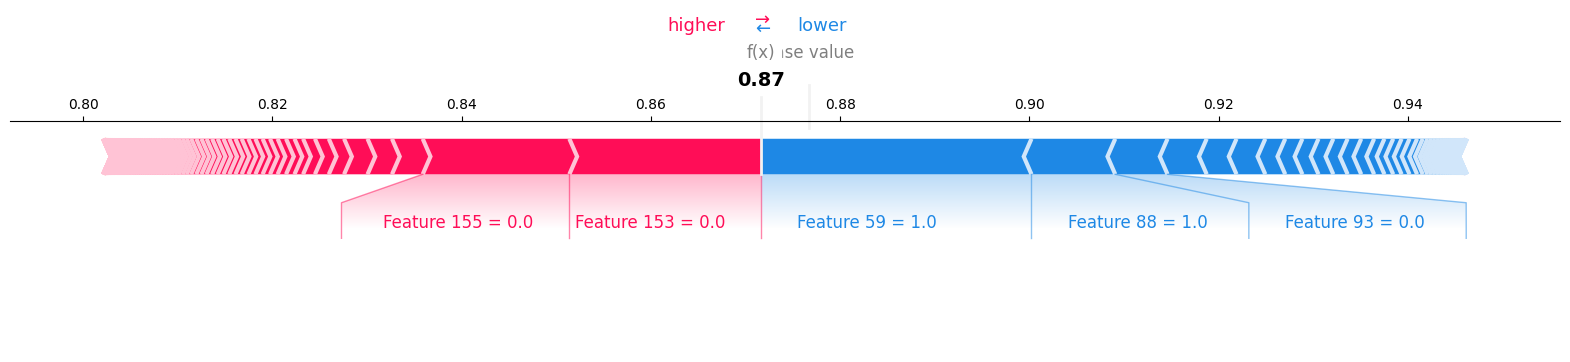

In [20]:
p(16)

In [21]:
X_test[16:17]

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 324,Feature 325,Feature 326,Feature 327,Feature 328,Feature 329,Feature 330,Feature 331,Feature 332,Feature 333
29013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,1,0


In [22]:
results[29013:29014]

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,Unnamed: 0,rxn_smiles,maccs,max_maccs_sim,maccs_1d
29013,29013,Cc1ccnc(Cl)c1.OB(O)c1cc(S)ccn1>>Cc1ccnc(-c2cc(...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.872503,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


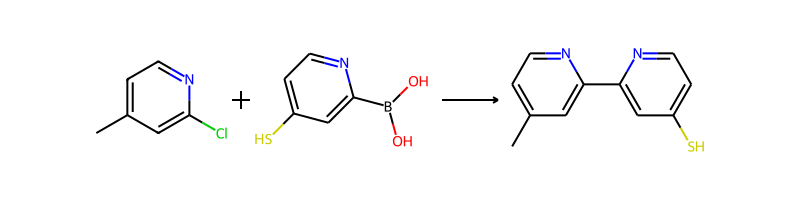

In [23]:
from rdkit.Chem import rdChemReactions
from rdkit.Chem.rdChemReactions import RemoveMappingNumbersFromReactions
rxn = AllChem.ReactionFromSmarts(results['rxn_smiles'][29013],useSmiles=True)
Chem.Draw.ReactionToImage(rxn)

In [24]:
AllChem.ReactionToSmiles(rxn)

'Cc1ccnc(Cl)c1.OB(O)c1cc(S)ccn1>>Cc1ccnc(-c2cc(S)ccn2)c1'

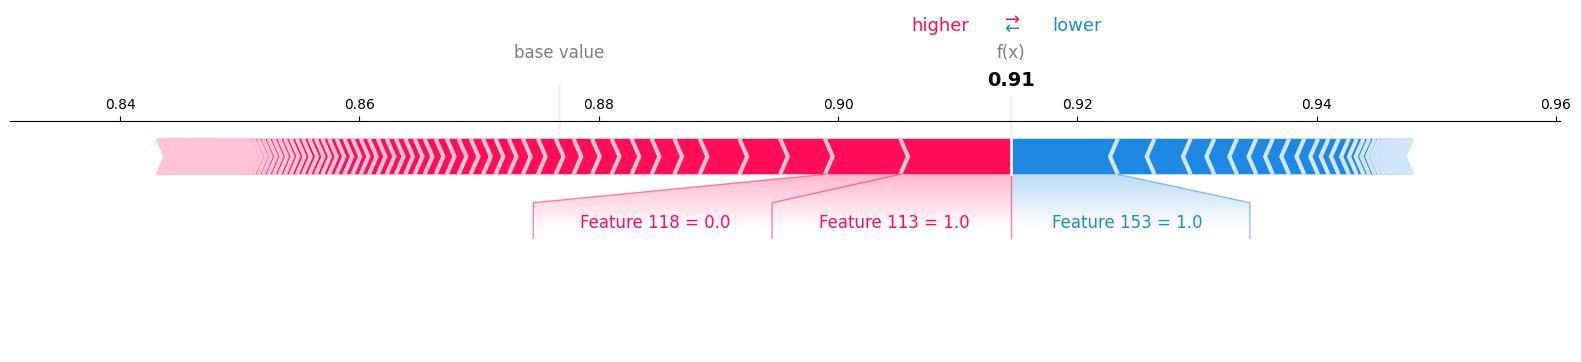

In [25]:
p(1900)

In [26]:
X_test[1900:1901]

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 324,Feature 325,Feature 326,Feature 327,Feature 328,Feature 329,Feature 330,Feature 331,Feature 332,Feature 333
17377,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,1,0


In [27]:
results[17377:17378]

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,Unnamed: 0,rxn_smiles,maccs,max_maccs_sim,maccs_1d
17377,17377,Oc1ccccc1Cl.OB(O)c1cccc(CCl)c1>>Oc1ccccc1-c1cc...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.923559,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


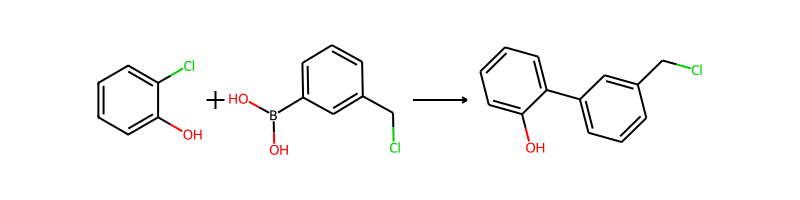

In [28]:
from rdkit.Chem import rdChemReactions
from rdkit.Chem.rdChemReactions import RemoveMappingNumbersFromReactions
rxn = AllChem.ReactionFromSmarts(results['rxn_smiles'][17377],useSmiles=True)
Chem.Draw.ReactionToImage(rxn)

In [29]:
AllChem.ReactionToSmiles(rxn)

'OB(O)c1cccc(CCl)c1.Oc1ccccc1Cl>>Oc1ccccc1-c1cccc(CCl)c1'

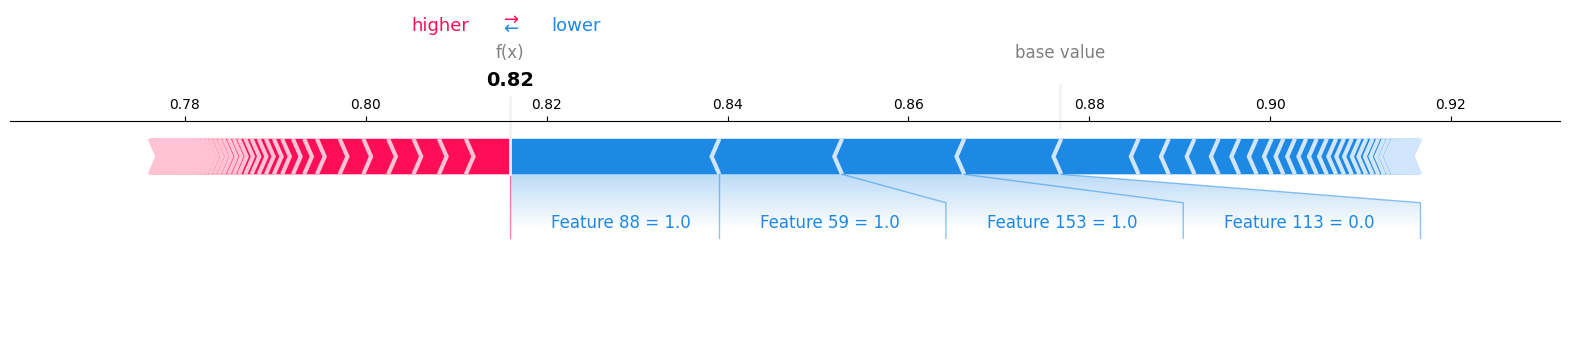

In [70]:
kk=2503
p(kk)

In [71]:
X_test[kk:kk+1]

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 324,Feature 325,Feature 326,Feature 327,Feature 328,Feature 329,Feature 330,Feature 331,Feature 332,Feature 333
54583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,1,0


In [72]:
results[54583:54584]

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,Unnamed: 0,rxn_smiles,maccs,max_maccs_sim,maccs_1d
54583,54583,CCCc1ccncc1Br.CCCSc1ccc(B(O)O)cn1>>CCCSc1ccc(-...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.809808,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


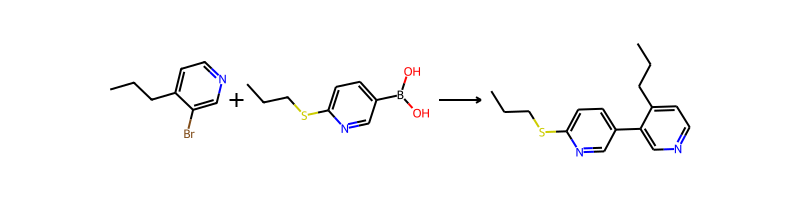

In [73]:
from rdkit.Chem import rdChemReactions
from rdkit.Chem.rdChemReactions import RemoveMappingNumbersFromReactions
rxn = AllChem.ReactionFromSmarts(results['rxn_smiles'][54583],useSmiles=True)
Chem.Draw.ReactionToImage(rxn)

In [74]:
AllChem.ReactionToSmiles(rxn)

'CCCSc1ccc(B(O)O)cn1.CCCc1ccncc1Br>>CCCSc1ccc(-c2cnccc2CCC)cn1'

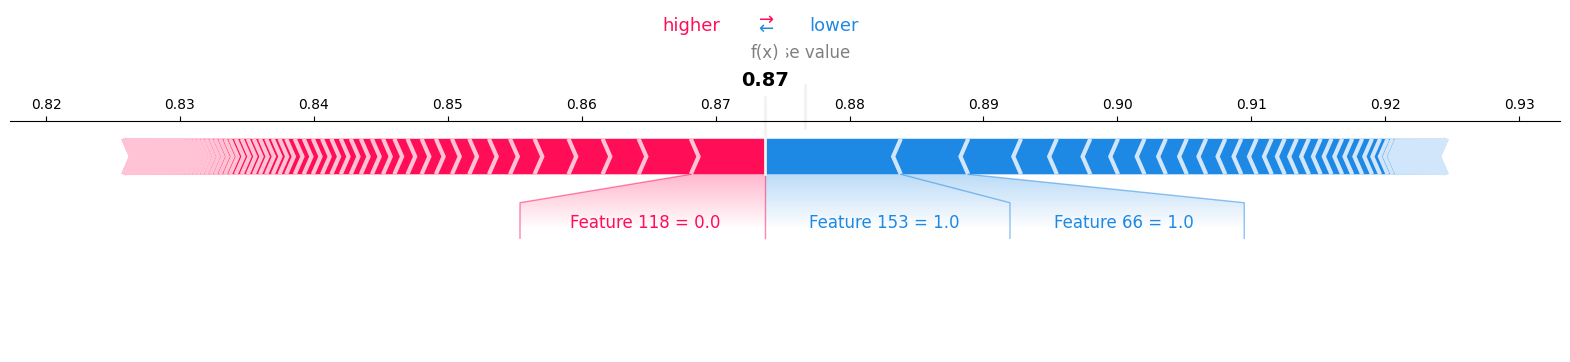

In [30]:
kk=2555
p(kk)

In [123]:
# for kk in range(2530, 2550):
#     p(kk)   

In [31]:
X_test[kk:kk+1]

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 324,Feature 325,Feature 326,Feature 327,Feature 328,Feature 329,Feature 330,Feature 331,Feature 332,Feature 333
84508,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,1,1,1,0


In [32]:
index = X_test.iloc[kk:kk+1].index
index[0]

84508

In [133]:
results[index[0]:index[0]+1]

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,Unnamed: 0,rxn_smiles,maccs,max_maccs_sim,maccs_1d
84508,84508,Cc1nccnc1Br.CC(C)(CO)c1c(B(O)O)ccc2ccccc12>>Cc...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.880799,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


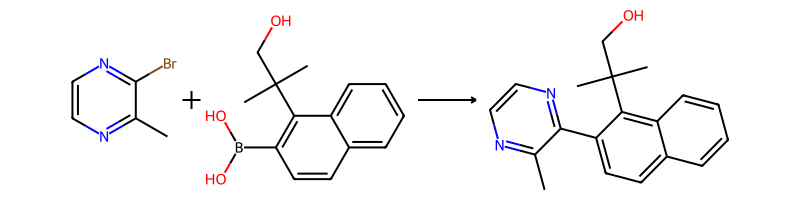

In [134]:
from rdkit.Chem import rdChemReactions
from rdkit.Chem.rdChemReactions import RemoveMappingNumbersFromReactions
rxn = AllChem.ReactionFromSmarts(results['rxn_smiles'][index[0]],useSmiles=True)
Chem.Draw.ReactionToImage(rxn)

In [135]:
AllChem.ReactionToSmiles(rxn)

'CC(C)(CO)c1c(B(O)O)ccc2ccccc12.Cc1nccnc1Br>>Cc1nccnc1-c1ccc2ccccc2c1C(C)(C)CO'